# Time Series Analysis Tool

This notebook exists to allow time series analysis of pixels or areas.

This notebook has been setup to work with table of contents and heading collapsing extensions. These are definitely worth using!

The output is an interactive matplotlib figure with two scenes from the area of interest rendered in true colour, along with scatter plots for the two main bands of interest for each scene, and an average spectral signature for each scene.

The main benefit to this visualistion though is the ability to see the the time series trend for a band or number of bands for a given pixel or area. This is one in a single chart, which also indicates the relative location of each of the scenes being viewed on the timeseries, and also shows some key threshold lines.

This particular notebook has been written to look at output from Peter's urban change detection algorithm, however, it is hoped that it should easily by ported to others' anaylsis problems with only minor tweaks, as long as the Xarray is setup the same, all that should be required is to:
<ul><li> exclude the code that displays the urban change algorithm outputs
<li> exclude the problem specific code (such as thresholds and change date range) on the TS analysis plot</ul>

## Imports

In [2]:
%matplotlib notebook
import os

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import gdal

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
from IPython.display import display

from skimage import exposure
from scipy.signal import lfilter

import warnings

# Setup

The goal is to get the data into an Xarray. The graphing code is written to work with an Xarray with the coordinates/dimensions (X, Y, time, bands).

## Importing the data
This code is specific to the intermediate output files from Peter's urban change algorithm.

In [3]:
# build a list of all files in the directory (ie the folder for that location)
location = 'mtbarker/'
files = os.listdir(location)

# build a list of all the NBAR*.img file names and which bands they represent
NBARfiles = []
bands = []
for file in files:
    if file[-4::] == '.img' and file[0:4] == 'NBAR':
        NBARfiles.append(file)
        bands.append(file.split('NBAR_')[1].split('.img')[0])

# open all the .img files with NBAR in the name, convert to numpy array, swap axes so order is (x, y, t)
# and save to dict
raw_data = {}
for i in range(len(NBARfiles)):
    raw_data[bands[i]] = gdal.Open(location + NBARfiles[i]).ReadAsArray().swapaxes(0,2)
num_scenes = len(raw_data['red'][0][0])

# build a list of all the dates represented by each band in the NBAR files
# reuse the list of NBAR file names, but this time access the .hdr file
in_dates = False
dates = []
for line in open(location + NBARfiles[0].split('.img')[0] + '.hdr'):
    if line[0] == '}':
        continue
    if in_dates:
        dates.append(line.split(',')[0].strip())
    if line[0:10] == 'band names':
        in_dates = True

# save list of satellite originated bands
sat_bands = bands.copy()

# add the yet to be calculated derivative bands to the overall bands list
bands += ['evi', 'ndvi', 'albedo', 'cloud_mask']

### Building the Xarray

In [4]:
# define the size for the numpy array that will hold all the data for conversion into XArray
x = len(raw_data['red'])
y = len(raw_data['red'][0])
t = len(raw_data['red'][0][0])
n = len(bands)

# create an empty numpy array of the correct size
alldata = np.zeros((x, y, t, n), dtype=np.float32)

# populate the numpy array with the satellite data
# turn all no data NBAR values to NaNs
for i in range(len(sat_bands)):
    alldata[:,:,:,i] = raw_data[sat_bands[i]]
    alldata[:,:,:,i][alldata[:,:,:,i] == -999] = np.nan
    
# convert the numpy array into an xarray, with appropriate lables, and axes names
data = xr.DataArray(alldata, coords = {'x':range(x), 'y':range(y), 'date':dates, 'band':bands},
             dims=['x', 'y', 'date', 'band'])

### Opening the results from the urban change algorithm

In [5]:
# open the results of the change algorithm, and format for eay plotting
change = gdal.Open(location + 'change_time.img').ReadAsArray()

# remove the dates, so you have a mask for change or no change
change_flat_mask = change.copy()
change_flat_mask[change_flat_mask != 0] = 1
change_flat_mask[change_flat_mask == 0] = np.nan

### Creating the calculated "bands"

In [6]:
# calculate NDVI "band"
a = (data.loc[:,:,:,'nir'] - data.loc[:,:,:,'red'])
b = (data.loc[:,:,:,'nir'] + data.loc[:,:,:,'red'])
b_pos = b.where(b.values > 0)
data.loc[:,:,:,'ndvi'] = np.nan
data.loc[:,:,:,'ndvi'] = a/b_pos

# calculate EVI "band"
g  = 2.5
c1 = 6
c2 = 7.5
l  = 1
data.loc[:,:,:,'evi'] = g * ((a/10000) /
    ((data.loc[:,:,:,'nir']/10000) + (c1 * (data.loc[:,:,:,'red']/10000)) - (c2 * (data.loc[:,:,:,'blue']/10000)) + l))

# calculate average albedo "band"
for band in sat_bands:
    data.loc[:,:,:,'albedo'] += data.loc[:,:,:,band]
data.loc[:,:,:,'albedo'] = data.loc[:,:,:,'albedo'] / (6 * 1000)

# import cloudmask and add to xarray
cloudmask = gdal.Open(location + '/tsmask.img').ReadAsArray().swapaxes(0,2)
data.loc[:,:,:,'cloud_mask'] = cloudmask

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


# Defining Functions

In [10]:
def drawScene(scene_num, change_trans, xpos, ypos):
    """
    This function draws a landsat scene from the data in true colour, and overlays the results of the
    change detection algorithm. The scene to be displayed is determined by the scene_num parameter, while the
    transparency (alpha) of the change results is dictacted by the change_trans parameter (0 = transparent,
    1 = totally opaque). It formats the axes appropriately and returns the axes to the caller.
    It also displays the bounding box of the pixels being analysed.
    """
    # colour map included incase of need to display false colour or other in the future
    # could change this to an ordereddict and remove the RGB list created below...?
    colourmap = {'R':'red', 'G':'green', 'B':'blue'}
    
    # define the current colour map to display the change results raster properly
    current_cmap = matplotlib.cm.get_cmap('Reds_r')
    current_cmap.set_under('k', alpha=0.0)
    current_cmap.set_over('r', alpha=1.0)
    current_cmap.set_bad('k', alpha=0.0)  
    
    # combine the data for the 3 bands to be displayed into a single numpy array
    h = data.shape[1]
    w = data.shape[0]
    RGB = ['R','G','B']
    
    # create array to store the RGB info in, and fill by looping through the colourmap variable
    # note the .T at the end, because the data array is setup as a (x,y,t), but imshow works (y,x)
    rawimg = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(len(RGB)):     
        rawimg[:,:,i] = data[:,:,scene_num].sel(band=colourmap[RGB[i]]).T
        
    # equalizing for all bands together
    # goal is to make is human interpretable
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))    

    # displaying the results and formatting the axes etc
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('True Colour Landsat Scene, taken\n' + dates[scene_num] + ', over ' + location[:,-1])
    ax.imshow(change_flat_mask, alpha = change_trans, interpolation='none', cmap = current_cmap, clim = [0.5, 0.6])
    
    # plot up the displayed pixel, or draw a box around the queried pixels
    # logic re . vs box could be improved here
    height = abs(ypos[1] - ypos[0])
    width = abs(xpos[1] - xpos[0])
    if height > 2 and width > 2:
        rect = matplotlib.patches.Rectangle((xpos[0],ypos[0]), abs(xpos[1] - xpos[0]), abs(ypos[1] - ypos[0]),
                                            color = 'blue', linestyle = '-', fill = False, alpha = change_trans)
        ax.add_patch(rect)
    else:
        ax.plot((xpos[0] + xpos[1])/2, (ypos[0] + ypos[1])/2, color = 'b', marker = '.', alpha = change_trans)
    return ax

<IPython.core.display.Javascript object>


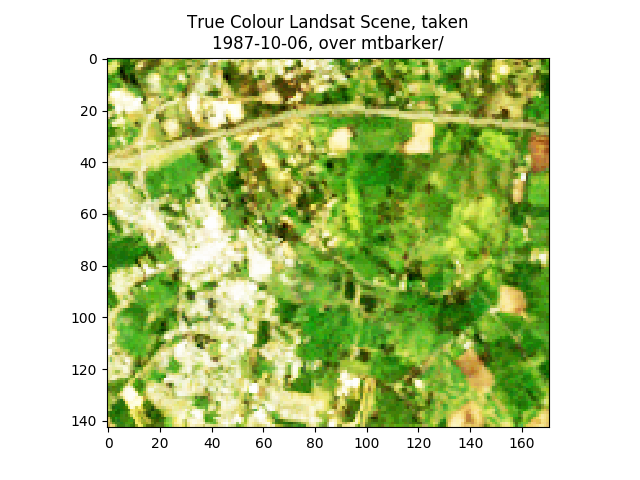

TypeError: Image data cannot be converted to float

In [12]:
ax = drawScene(1, 0, [0,0],[0,0])
imshow(ax)